In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing required libraries

In [38]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import Xception
from PIL import Image

## Loading dataset

In [39]:
DATASET_PATH = "/kaggle/input/skin-cancer-malignant-vs-benign/"
TRAIN_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
TEST_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'

dir_benign_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/benign'
dir_malignant_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant'
dir_benign_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign'
dir_malignant_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant'

#Loading images and converting them to numpy array using their RGB value
read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))

### Loading Test Images

In [40]:
img_benign_test = [read(os.path.join(dir_benign_test, filename)) for filename in os.listdir(dir_benign_test)]
img_malignant_test = [read(os.path.join(dir_malignant_test, filename)) for filename in os.listdir(dir_malignant_test)]

### Loading Training images

In [41]:
img_benign_train = [read(os.path.join(dir_benign_train, filename)) for filename in os.listdir(dir_benign_train)]
img_malignant_train = [read(os.path.join(dir_malignant_train, filename)) for filename in os.listdir(dir_malignant_train)]

## Getting information of dataset

In [42]:
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 3 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test
There are 0 directories and 360 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign
There are 0 directories and 300 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test/malignant
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train
There are 0 directories and 1440 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train/benign
There are 0 directories and 1197 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/test
There are 0 directories and 360 images in /kaggle/input/skin-cancer-malignant-vs-benign/tes

In [43]:
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpg")

In [44]:
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2637
test samples count:		660
TOTAL:				3297


In [45]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]

def build_df(image_paths, labels):
    df = pd.DataFrame({'image_path': image_paths,'label': generate_labels(labels)})
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)


In [46]:
class CFG:
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    IMAGE_SIZE = (224, 224, 3)

<Axes: ylabel='label'>

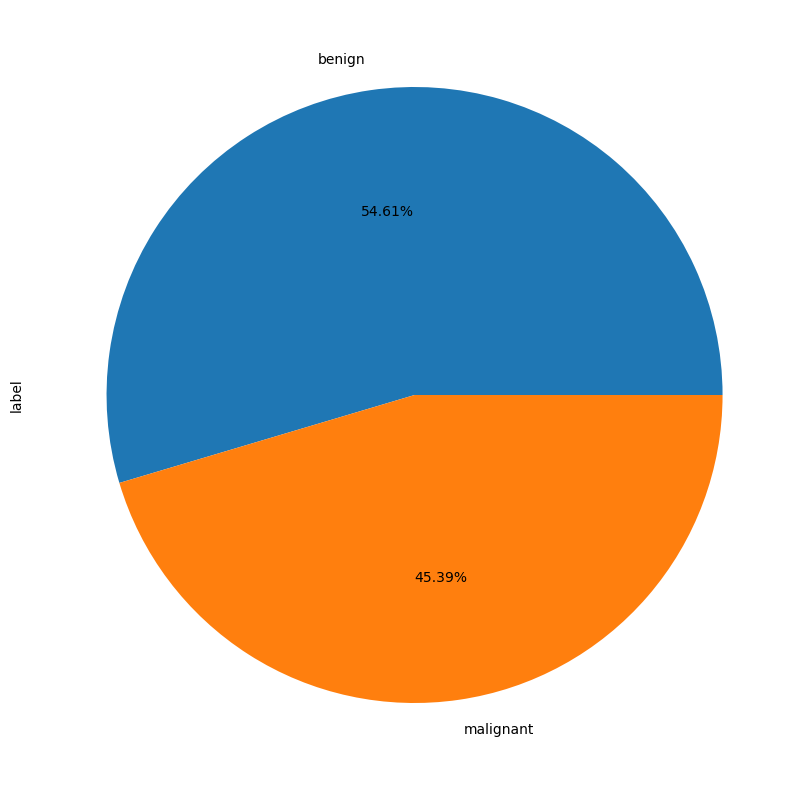

In [47]:
root_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/data/train/*/*.jpg"
images = glob.glob(root_dir)
df = pd.DataFrame({"filepath": images})
df["label"] = df["filepath"].str.split("/", expand=True)[6]
df["label"].value_counts().plot(kind="pie", autopct="%.2f%%",figsize=(10, 10))

In [48]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [49]:
train_df.tail(9)

,image_path,label,label_encoded
2628,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2629,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2630,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2631,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,0
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,0
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2636,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1


In [50]:
X_benign_train = np.array(img_benign_train)
X_malignant_train = np.array(img_malignant_train)

X_benign_test = np.array(img_benign_test)
X_malignant_test = np.array(img_malignant_test)

In [51]:
y_benign_train = np.zeros(X_benign_train.shape[0])
y_malignant_train = np.ones(X_malignant_train.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

y_malignant_train

array([1., 1., 1., ..., 1., 1., 1.])

In [52]:
X_train = np.concatenate((X_benign_train, X_malignant_train), axis=0) 
y_train = np.concatenate((y_benign_train, y_malignant_train), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2637, 224, 224, 3)
Shape of y_train:  (2637,)
Shape of X_test:  (660, 224, 224, 3)
Shape of y_test:  (660,)


In [53]:
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
X_train = X_train[s1]
y_train = y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]

## View multiple random samples

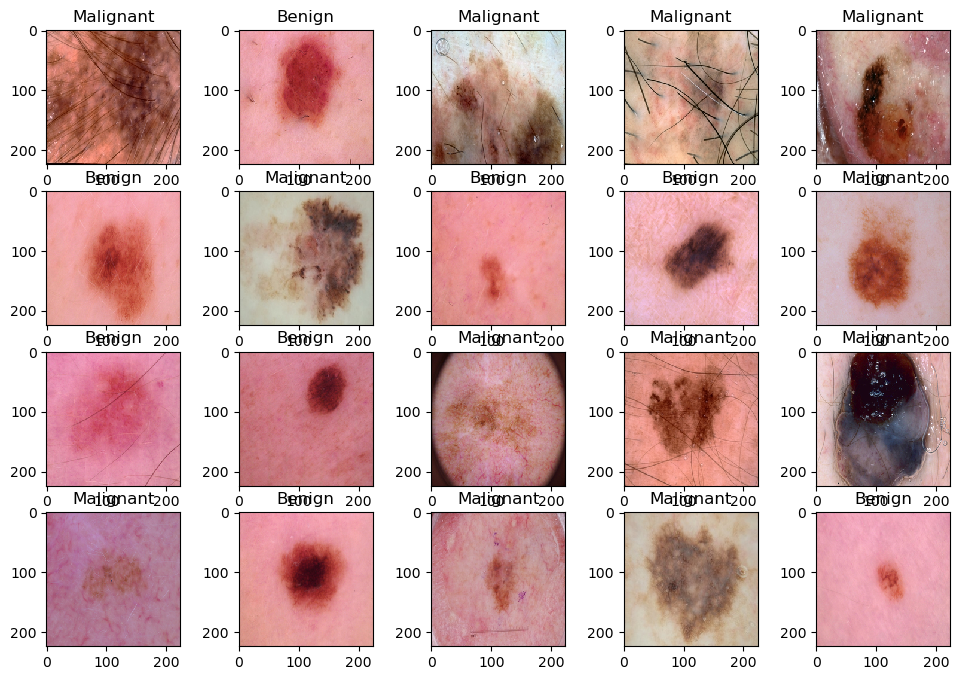

In [54]:
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 4

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [55]:
# # Select random sample from train_df
# idx = random.sample(train_df.index.to_list(), 1)[0]

# # Load the random sample and label
# sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# # View the random sample
# fig = plt.figure(figsize=(3,3))
# view_sample(sample_image, sample_label)

In [56]:
import keras
from keras.utils.np_utils import to_categorical 

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [57]:
#Normalization
X_train = X_train/255
X_test = X_test/255

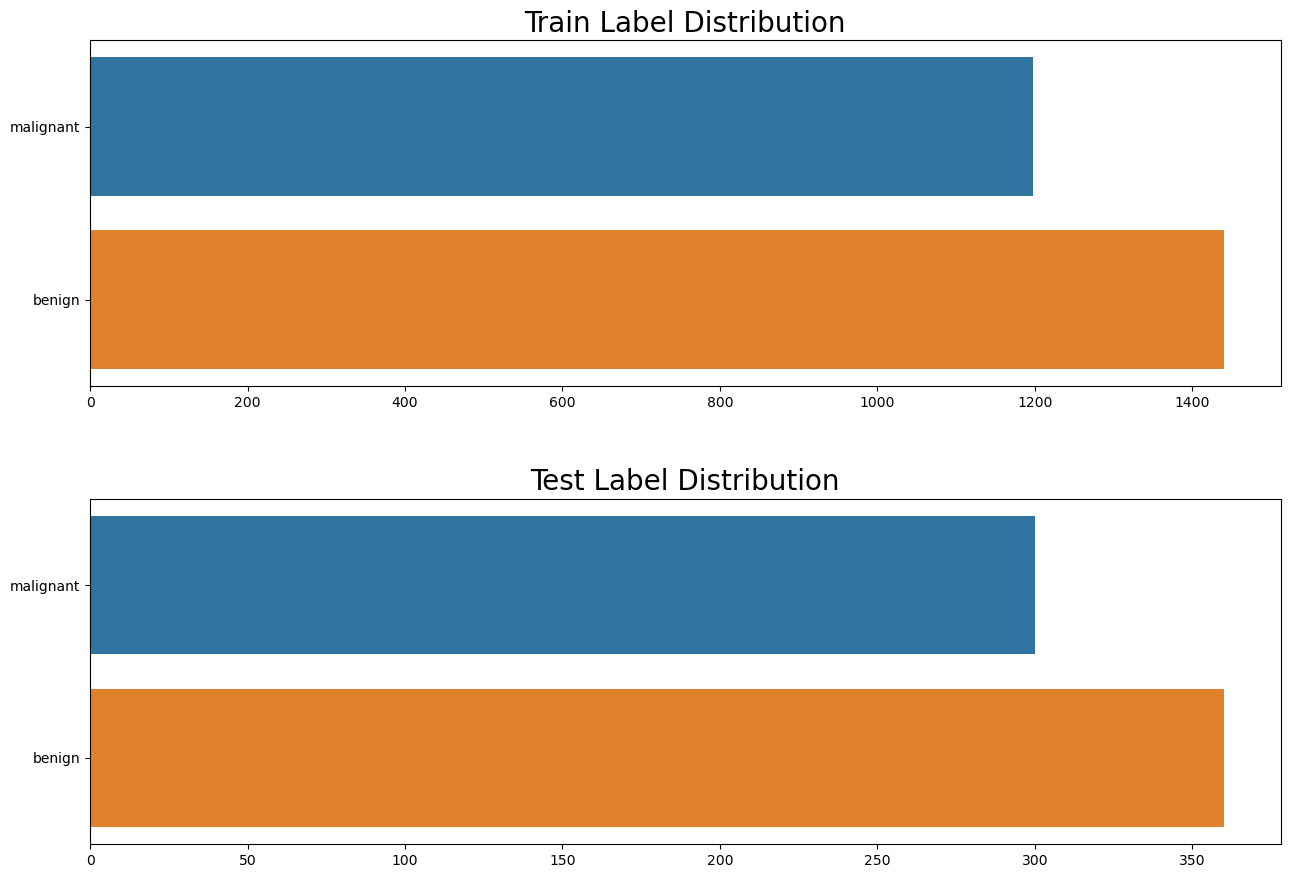

In [58]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
fig.tight_layout(pad=6.0)

ax1.set_title('Train Label Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,y=list(train_distribution.index),orient="h",ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Label Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,y=list(test_distribution.index),orient="h",ax=ax2)

plt.show()


## Building  CNN mode

In [59]:
def build_cnn_model(input_shape = (224, 224, 3), num_classes=2):
    
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', input_shape = input_shape, activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.25)) 
    
    
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.summary()

    optimizer= Adam(lr=0.001) 
    
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=["accuracy"])
    
    return model   

In [60]:
model_cnn = build_cnn_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [61]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       

## Neural Network Diagram


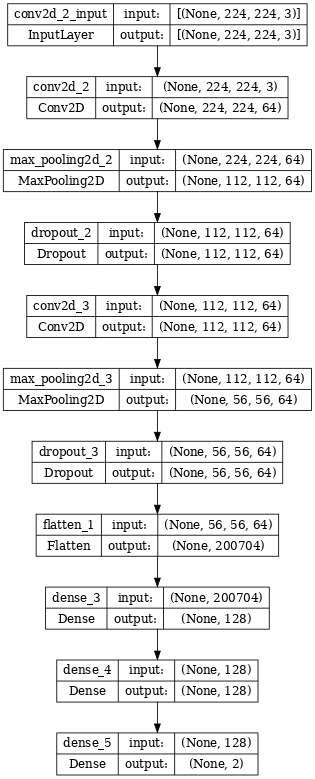

In [62]:
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

In [63]:
# learning_rate_annealer = ReduceLROnPlateau(monitor='val_acc',patience=5, verbose=1, factor=0.5, min_lr = 1e-7)
# history = model_cnn.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size = 64, verbose=1, callbacks=[learning_rate_annealer])
# print(history.history.keys())

In [64]:

history = model_cnn.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size = 64, verbose=1)
print(history.history.keys())

Epoch 1/15


2023-07-15 04:38:33.930320: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 [==============================] - 11s 311ms/step - loss: 1.2142 - accuracy: 0.5401 - val_loss: 0.6565 - val_accuracy: 0.6439
Epoch 2/15
33/33 [==============================] - 9s 284ms/step - loss: 0.5935 - accuracy: 0.6733 - val_loss: 0.5634 - val_accuracy: 0.6383
Epoch 3/15
33/33 [==============================] - 10s 294ms/step - loss: 0.5105 - accuracy: 0.7454 - val_loss: 0.5143 - val_accuracy: 0.6875
Epoch 4/15
33/33 [==============================] - 9s 286ms/step - loss: 0.4378 - accuracy: 0.7824 - val_loss: 0.4766 - val_accuracy: 0.7633
Epoch 5/15
33/33 [==============================] - 10s 296ms/step - loss: 0.4235 - accuracy: 0.7824 - val_loss: 0.4880 - val_accuracy: 0.7386
Epoch 6/15
33/33 [==============================] - 10s 293ms/step - loss: 0.4254 - accuracy: 0.7966 - val_loss: 0.4826 - val_accuracy: 0.7519
Epoch 7/15
33/33 [==============================] - 10s 295ms/step - loss: 0.3760 - accuracy: 0.8160 - val_loss: 0.4811 - val_accuracy: 0.7348
Epoch 8/15
3

## Plot for Model Accuracy & Model Loss

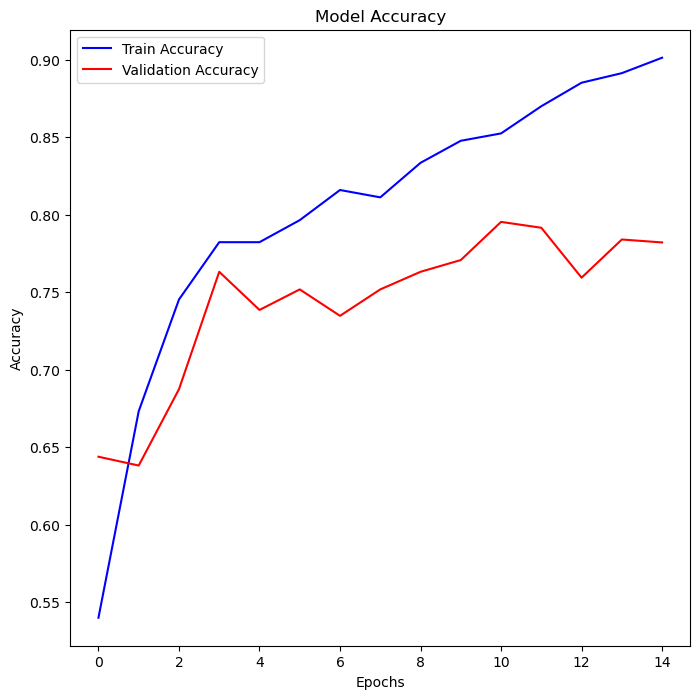

In [65]:
plt.figure(figsize = (8, 8))
plt.plot(history.history['accuracy'], color = 'b')
plt.plot(history.history['val_accuracy'], color = 'r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

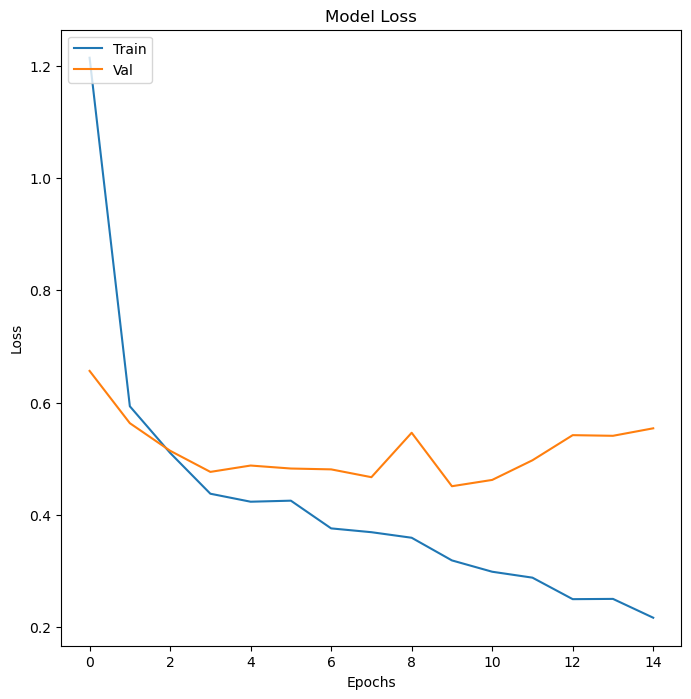

In [66]:
plt.figure(figsize = (8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Testing model on test data to evaluate / Evaluation of the model

In [77]:
y_pred = np.argmax(model_cnn.predict(X_test), axis=-1)
print("Accuracy : ",accuracy_score(np.argmax(y_test, axis=1),y_pred))
print("Accuracy : ",.8939474844932556)


Accuracy :  0.8939474844932556


In [68]:
#confusion matrix
def labels_confusion_matrix(test_folder):
    
    folder_path=test_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(299,299))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 2
    cmap="OrRd"
    cm_plot_labels = [i for i in range(2)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) 
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()


In [69]:
!pip install segmentation-models

## Deployment of the model

1/1 [==============================] - 0s 90ms/step


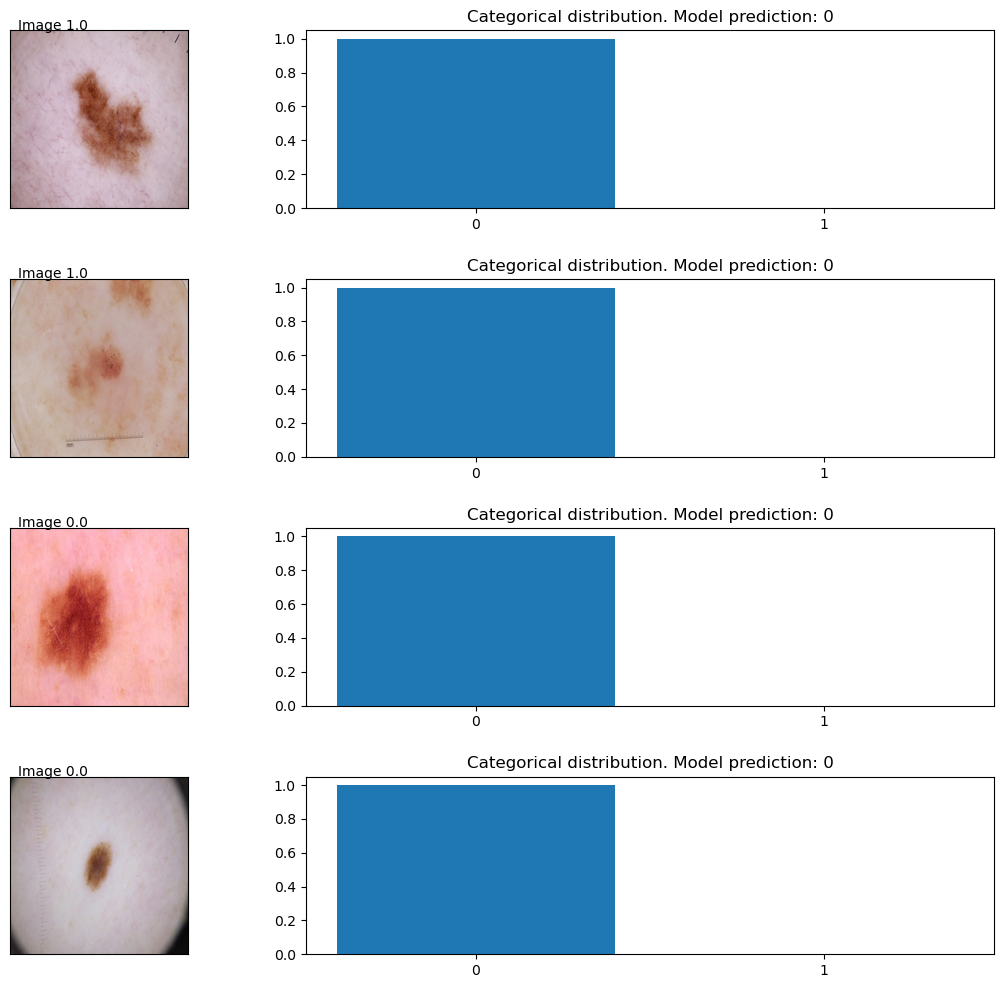

In [80]:
num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images,4)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_cnn.predict(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Image {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()

## Check the prediction of the model

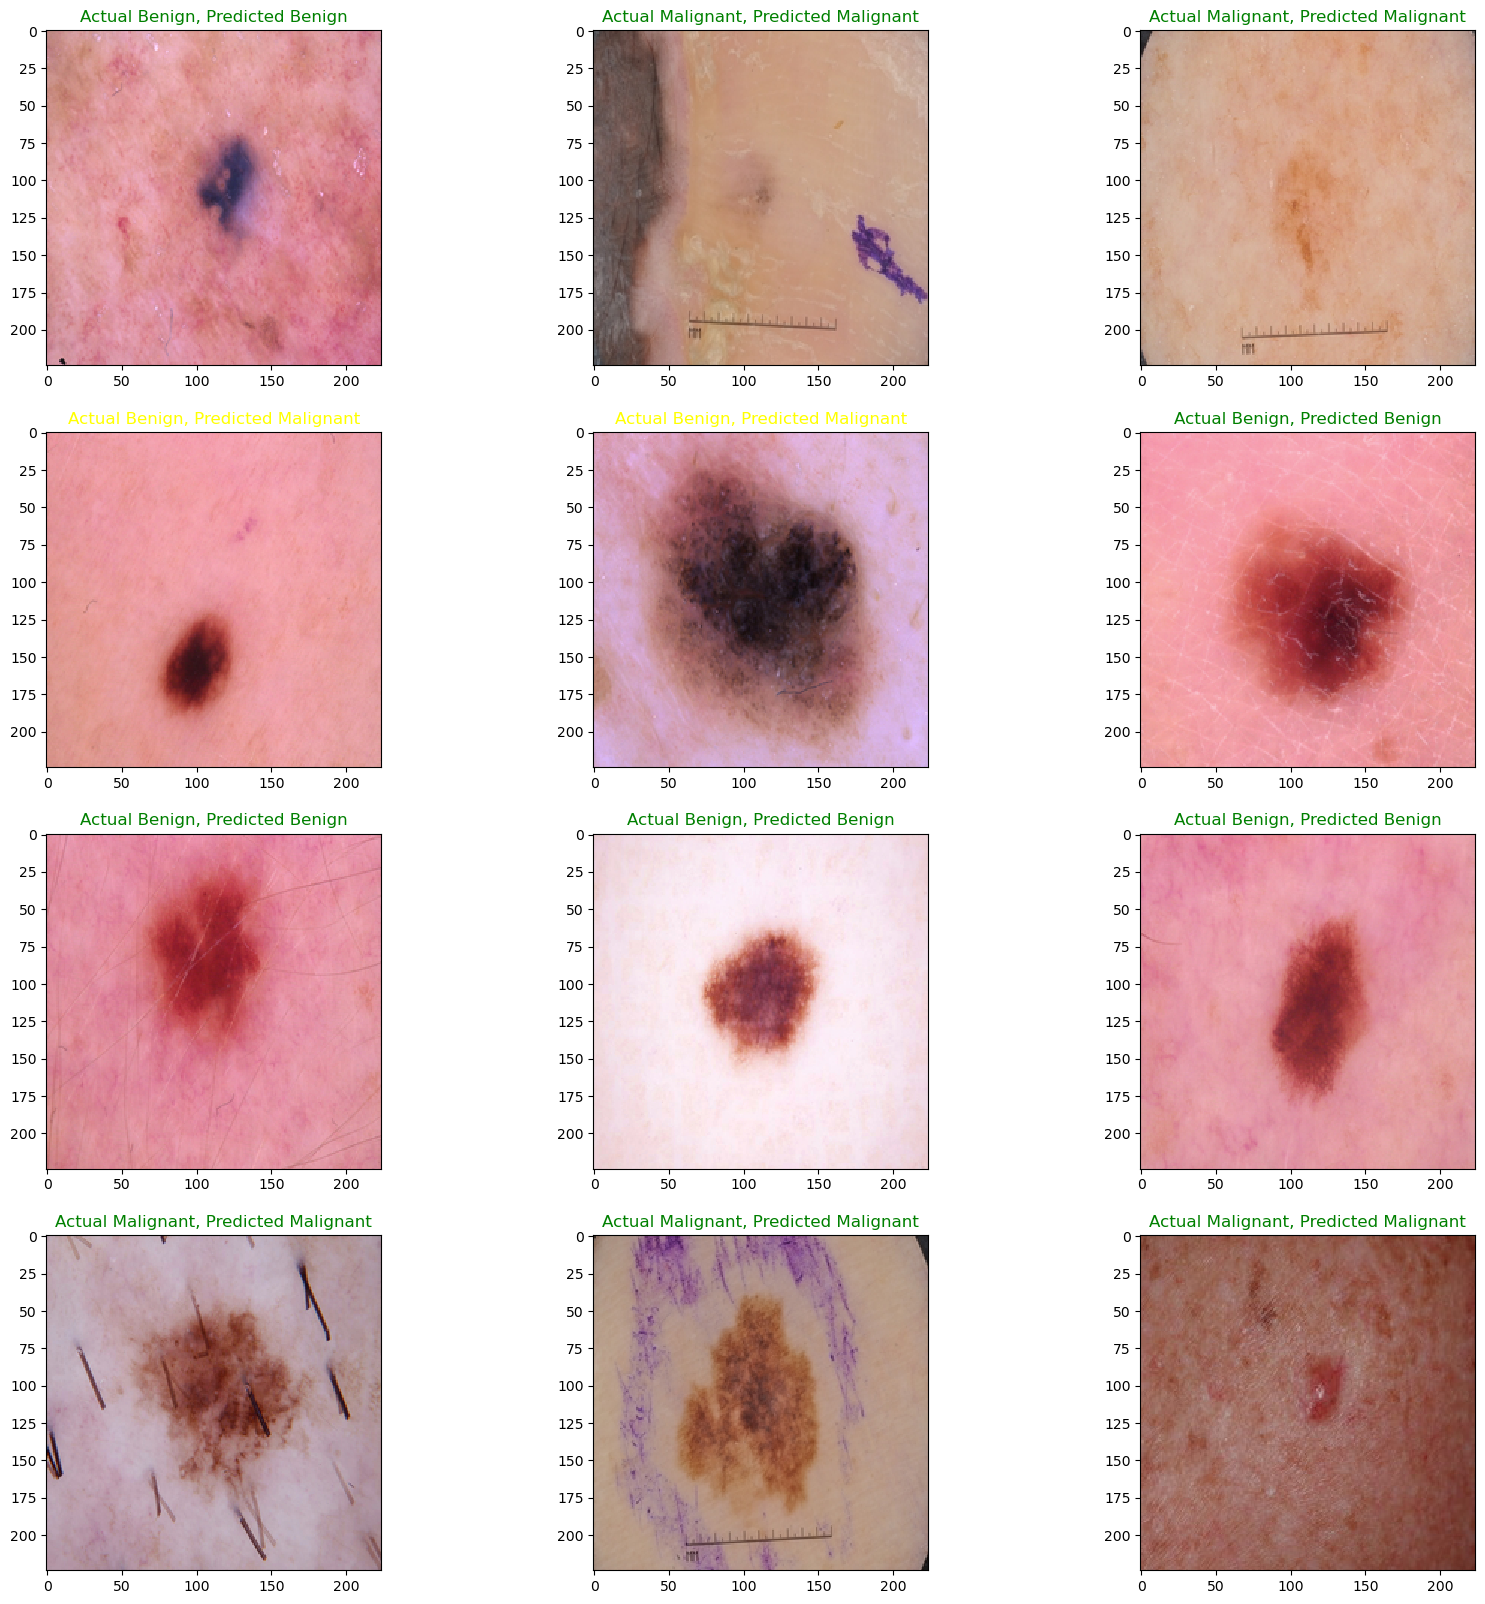

In [79]:
X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

# shuffling data
s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]
y_pred = y_pred[s2]

# plotting
fig = plt.figure(figsize=(20,20))
columns = 3
rows = 4

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_test[i] == 1:       
        if y_pred[i] == 1:
            ax.set_title('Actual Malignant, Predicted Malignant', color='green')
        else:
            ax.set_title('Actual Malignant, Predicted Benign', color='red')
    
    else:
        if y_pred[i] == 0:
            ax.set_title('Actual Benign, Predicted Benign', color='green')
        else:
            ax.set_title('Actual Benign, Predicted Malignant', color='yellow')

        
    plt.imshow(X_test[i], interpolation='nearest')
plt.show()


## Saving the model

In [ ]:
from tensorflow.keras.models import save_model
save_model(model_cnn, '/kaggle/working/skin_cnn_model.h5')

In [ ]:
!pip install gradio